## Figure S7B

In [1]:
# Preliminaries to work with the data.   
%matplotlib inline
%run __init__.py
from utils import loading, scoring, prog
from gerkin import dream,params,fit2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load CIDs for all relevant molecules.  
# dream: from the DREAM challenge
# new: from new unpublished data collected by A. Keller.
# shared: the overlap
dream_CIDs = loading.get_CIDs(['training','leaderboard','testset'])
df_new_CIDs = pd.read_csv('../../data/newdata_cids.txt',delimiter='\t',index_col=0,header=None,names=['CID'])['CID']
new_CIDs = list(df_new_CIDs)
shared_CIDs = list(set(dream_CIDs).intersection(new_CIDs))
dream_only_CIDs = list(set(dream_CIDs).difference(new_CIDs))
new_only_CIDs = list(set(new_CIDs).difference(dream_CIDs))
                        # Delete this line when we get these features.  

In [3]:
# At time of publication, the features for one molecule, Bourgeonal, 
# had not been computed and included in the analysis.  
# We have since added the features for this molecule and updated the analysis, 
# with no qualitative change in the results.  

#new_CIDs.remove(64832) # Remove Bourgeonal since we have no Dragon features for it.
                        # Delete this line when we get these features.  
#new_only_CIDs.remove(64832) # Remove Bourgeonal since we have no Dragon features for it.
                        # Delete this line when we get these features.  

In [4]:
# Load all the perceptual data from the DREAM challenge.  
df_dream = loading.load_perceptual_data(['training','leaderboard','testset'])
df_dream.head()

Metadata         Subject  \
                                                    Name Solvent       1   
Descriptor CID Dilution Replicate                                          
Intensity  126 -3.0     0          4-Hydroxybenzaldehyde    None     7.0   
               -1.0     0          4-Hydroxybenzaldehyde    None    37.0   
           176 -7.0     0                    acetic acid    None     0.0   
               -5.0     0                    acetic acid    None     0.0   
           177 -5.0     0                   acetaldehyde    None     3.0   

                                                                             \
                                      2     3      4     5    6     7     8   
Descriptor CID Dilution Replicate                                             
Intensity  126 -3.0     0          55.0  89.0   29.0   0.0  0.0   6.0  46.0   
               -1.0     0          64.0   0.0  100.0  58.0  0.0  18.0  51.0   
           176 -7.0     0           0.0   0.0   20.0   0.0  0.0   0.0   0.0   
               -5.0     0          83.0  69.0    0.0  67.0  0.0   0.0  57.0   
           177 -5.0     0          60.0   0.0   10.0   0.0  0.0  83.0   0.0   

                                   ...                                      \
                                   ...     40    41   42    43    44    45   
Descriptor CID Dilution Replicate  ...                                       
Intensity  126 -3.0     0          ...    0.0   0.0  2.0  28.0  33.0  64.0   
               -1.0     0          ...   76.0  49.0  0.0  78.0  21.0  50.0   
           176 -7.0     0          ...    0.0   0.0  1.0   0.0  24.0  52.0   
               -5.0     0          ...    0.0   0.0  0.0   0.0   3.0   0.0   
           177 -5.0     0          ...   28.0   0.0  0.0  27.0  29.0  37.0   

                                                           
                                     46    47    48    49  
Descriptor CID Dilution Replicate                          
Intensity  126 -3.0     0           0.0   0.0   0.0  18.0  
               -1.0     0          50.0  85.0   9.0   7.0  
           176 -7.0     0           0.0   0.0   0.0   0.0  
               -5.0     0           0.0   0.0  14.0   0.0  
           177 -5.0     0          55.0   6.0   0.0   0.0  

[5 rows x 51 columns]

In [5]:
# Load and format the new unpublished perceptual data from A. Keller.  
df = pd.read_excel('../../data/0869 final data Pablo.xlsx',index_col=0,header=None).transpose().drop(1)
df = df.drop(df.loc[df['Subject Identifier']=='citronella'].index) # This is a mixture and so not used in this project
df = df.drop(df.loc[df['Subject Identifier']=='bourgeonal'].index) # I don't have Dragon features for this.  
                                                                  # Delete line when those features are available.  
mux = pd.MultiIndex.from_arrays(df.values[:,[0,3,1,2]].transpose(), names=['Descriptor','CID','Dilution','Solvent'])
df = pd.DataFrame(data=df.values[:,4:], index=mux, dtype=float)

# Compute log diliutions
dilutions = set(df.index.levels[2])
dilutions.remove('pure')
log_dilutions = {dilution:-np.round(np.log10(float(dilution[2:].replace(',',''))),2) for dilution in dilutions}
log_dilutions['pure'] = 0
df = df.rename(index=log_dilutions)

# Fix odorant names
odorants = {x:x.replace(' (1M solution)','').replace(' (w/v)','') for x in set(df.index.levels[1])}
df = df.rename(index=odorants)
df = df.rename(index={x:x.title() for x in df.index.levels[0]})

# Sort by descriptor, then odor, then solvent, then dilution
df = df.sortlevel() 

# Drop rows where the odorant is NaN.  
df = df.loc[~(df.index.labels[1] == -1)]

df.insert(0,'Name',[ix[1] for ix in df.index])
df.insert(1,'Solvent',[ix[3] for ix in df.index])
df = df.rename(index={name:int(df_new_CIDs.loc[name]) for name in df_new_CIDs.index})
#df = df.rename(columns={x:'S%d'%x for x in df.columns if type(x) is int})
df.index = df.index.droplevel('Solvent')
df.insert(1,'Replicate',[i % 2 for i in range(len(df.index))])
df = df.set_index('Replicate',append=True)
df = df.sortlevel()
df.columns = [['Metadata']*2+['Subject']*403,df.columns]
df_new = df.copy()
df_new.head()

Metadata               Subject              \
                                       Name       Solvent       0     1     2   
Descriptor CID Dilution Replicate                                               
Intensity  460 -6.0     0          guaiacol  paraffin oil    32.0   9.0  54.0   
                        1          guaiacol  paraffin oil     9.0  25.0  83.0   
               -5.0     0          guaiacol  paraffin oil     0.0   0.0   0.0   
                        1          guaiacol  paraffin oil     6.0   0.0   8.0   
               -4.0     0          guaiacol  paraffin oil    60.0  79.0  90.0   

                                                                 ...         \
                                      3     4     5     6     7  ...    393   
Descriptor CID Dilution Replicate                                ...          
Intensity  460 -6.0     0          32.0  38.0   0.0  73.0  61.0  ...    4.0   
                        1          40.0  56.0   0.0  74.0  15.0  ...    0.0   
               -5.0     0           0.0  11.0   0.0   3.0   0.0  ...    0.0   
                        1          17.0  63.0   0.0  11.0   6.0  ...    0.0   
               -4.0     0          82.0  71.0  18.0  80.0  66.0  ...   46.0   

                                                                             \
                                    394   395   396   397   398   399   400   
Descriptor CID Dilution Replicate                                             
Intensity  460 -6.0     0          49.0  39.0   0.0  12.0  25.0  19.0   0.0   
                        1          68.0  46.0  13.0   0.0   3.0  13.0  27.0   
               -5.0     0          12.0  49.0   0.0  53.0  15.0  12.0   0.0   
                        1          58.0  46.0   0.0   0.0  18.0   9.0  47.0   
               -4.0     0          79.0  56.0  88.0  67.0  35.0  20.0  78.0   

                                               
                                    401   402  
Descriptor CID Dilution Replicate              
Intensity  460 -6.0     0           6.0  31.0  
                        1          58.0  12.0  
               -5.0     0          12.0  23.0  
                        1          53.0  33.0  
               -4.0     0          72.0  62.0  

[5 rows x 405 columns]

In [6]:
# Make lits of all CIDs and dilutions for both datasets.  
dream_CID_dilutions = loading.get_CID_dilutions(['training','leaderboard','testset'])
new_CID_dilutions = [tuple(x[1:3]) for x in df_new.index.values]
all_CID_dilutions = set(dream_CID_dilutions + new_CID_dilutions)
dream_only_CID_dilutions = [x for x in dream_CID_dilutions if x[0] not in new_CIDs]
shared_CID_dilutions_old = [x for x in dream_CID_dilutions if x[0] in new_CIDs]
shared_CID_dilutions_new = [x for x in new_CID_dilutions if x[0] in dream_CIDs]
new_only_CID_dilutions = [tuple(x[1:3]) for x in df_new.index.values if x[1] not in dream_CIDs]

In [7]:
# Load the Dragon and Morgan features for all of the DREAM molecules.
dream_features = loading.get_molecular_data(['dragon','morgan'],dream_CIDs)
dream_features.head()

Dragon has 4869 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
There are now 7306 total features.


dragon                                                 \
    complexity from pubmed      MW    AMW      Sv      Se      Sp      Si   
CID                                                                         
126                   93.1  122.13  8.142  10.010  15.305  10.193  16.664   
176                   31.0   60.06  7.508   4.483   8.422   4.432   9.249   
177                   10.3   44.06  6.294   3.768   7.095   3.977   8.040   
180                   26.3   58.09  5.809   5.295   9.978   5.739  11.455   
196                  114.0  146.16  7.308  11.493  20.727  11.625  22.914   

                            ...       morgan                                \
        Mv     Me     Mp    ...     91305518  91411526  91541756  91552833   
CID                         ...                                              
126  0.667  1.020  0.680    ...     0.003578  0.018182  0.118421  0.017192   
176  0.560  1.053  0.554    ...     0.011152  0.014320  0.091603  0.030488   
177  0.538  1.014  0.568    ...     0.003731  0.009592  0.031008  0.018405   
180  0.530  0.998  0.574    ...     0.011152  0.014320  0.061069  0.030488   
196  0.575  1.036  0.581    ...     0.032086  0.027149  0.116883  0.096866   

                                                                 
     91563027  91595028  91614181  91617014  91617930  91618238  
CID                                                              
126  0.145251  0.013652  0.056206  0.047945  0.011730  0.105263  
176  0.037975  0.009695  0.024631  0.036900  0.015129  0.064516  
177  0.025641  0.002774  0.009901  0.014870  0.006070  0.043956  
180  0.025316  0.009695  0.024631  0.044280  0.015129  0.043011  
196  0.044199  0.028630  0.055944  0.074830  0.046784  0.103448  

[5 rows x 7306 columns]

In [8]:
# Load Dragon features for all of the "new" molecules.  
new_features = pd.read_excel('../../data/dragon descriptors for 0869 odors.xlsx',index_col=0)
# Bourgeonal features were not computed until later.  
bourgeonal_features= pd.read_csv('../../data/CID64832_dragon_descriptors.txt',delimiter='\t',index_col=1).drop('No.',1)
bourgeonal_features.index.name = 'CID'
new_features = pd.concat((new_features,bourgeonal_features))
new_features.head()

,AAC,AECC,ALOGP,ALOGP2,AMR,AMW,AROM,ARR,ASP,ATS1e,...,piPC01,piPC02,piPC03,piPC04,piPC05,piPC06,piPC07,piPC08,piPC09,piPC10
CID,,,,,,,,,,,,,,,,,,,,,
7794,1.124,6.364,3.019,9.114,49.297,5.320,0.0,0.0,0.709,3.342,...,2.565,2.773,2.639,2.639,2.485,2.565,2.197,2.197,0.000,0.000
8164,1.198,7.917,3.175,10.078,49.690,5.384,0.0,0.0,0.906,3.460,...,2.565,2.639,2.398,2.303,2.197,2.079,1.946,1.792,1.609,1.386
8842,1.094,6.364,3.049,9.297,50.486,5.042,0.0,0.0,0.448,3.417,...,2.485,2.708,2.565,2.485,2.398,2.485,1.946,1.609,0.000,0.000
10409,1.068,7.188,5.280,27.881,69.656,5.101,0.0,0.0,0.175,3.777,...,2.890,2.996,2.996,2.996,2.996,2.996,2.996,2.996,2.996,2.996
10947,1.061,7.353,5.532,30.603,74.205,5.074,0.0,0.0,0.178,3.841,...,2.944,3.091,3.091,3.178,3.091,3.091,3.091,3.091,3.091,3.091


In [9]:
# Make a single data frame will all of these features, but only use Dragon ones because we didn't
# compute the Morgan fingerprints for the new molecules.
all_features = pd.concat([dream_features['dragon'].drop('complexity from pubmed',1),new_features])
all_features.head()

,AAC,AECC,ALOGP,ALOGP2,AMR,AMW,AROM,ARR,ASP,ATS1e,...,piPC01,piPC02,piPC03,piPC04,piPC05,piPC06,piPC07,piPC08,piPC09,piPC10
CID,,,,,,,,,,,,,,,,,,,,,
126,1.429,4.444,1.322,1.748,34.343,8.142,1.0,0.667,0.580,2.810,...,2.639,3.114,3.590,3.987,4.467,4.176,3.446,0.0,0.0,0.0
176,1.500,1.750,-0.230,0.053,12.644,7.508,0.0,0.000,0.256,2.167,...,1.609,1.792,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0
177,1.379,1.667,-0.182,0.033,11.718,6.294,0.0,0.000,0.672,1.959,...,1.386,1.099,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0
180,1.295,1.750,-0.244,0.060,16.195,5.809,0.0,0.000,0.215,2.300,...,1.609,1.792,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0
196,1.485,5.800,0.502,0.252,32.739,7.308,0.0,0.000,0.798,3.061,...,2.485,2.708,2.303,2.197,2.079,1.946,2.303,0.0,0.0,0.0


In [10]:
# Create the feature and descriptor arrays 
X,good1,good2,means,stds,imputer = dream.make_X(all_features,all_CID_dilutions)

The X matrix now has shape (886x3083) molecules by non-NaN good molecular descriptors


In [11]:
# Functions to select only the appropriate dilutions (to match the challenge rules).
def intensity_dilutions(CID_dilutions):
    int_CID_dilutions = []
    CIDs = list(set([x[0] for x in CID_dilutions]))
    for CID in CIDs:
        dilutions = np.array([dilution for CID_,dilution in CID_dilutions if CID_==CID])
        rel_dilutions = np.abs(dilutions + 3)
        int_CID_dilutions += [(CID,dilutions[rel_dilutions.argmin()])]
    return int_CID_dilutions

def max_dilutions(CID_dilutions):
    max_CID_dilutions = []
    CIDs = list(set([x[0] for x in CID_dilutions]))
    for CID in CIDs:
        dilutions = np.array([dilution for CID_,dilution in CID_dilutions if CID_==CID])
        max_CID_dilutions += [(CID,dilutions.max())]
    return max_CID_dilutions

### Compute the random forest model

In [12]:
# Fit the models for each scenario.  
# In all cases, the model is trained with the molecules used in the DREAM challenge.  
# There are 4 test cases, corresponding to: 
# old_old: The molecules common to DREAM and the new data, using the same subjects (i.e. in sample)
# old_new: Same as above, but using data from the new subjects.  
# new_new: Only new molecules not used in the DREAM challenge, using new subjects.  
# new: Combination of the last two, using new subjects but a combination of old and new molecules.  
from sklearn.ensemble import RandomForestRegressor
use_et, max_features, max_depth, min_samples_leaf, trans_weight, regularize, use_mask = params.get_other_params()
kinds = {'old_old':shared_CID_dilutions_old,
         'old_new':shared_CID_dilutions_new,
         'new_new':new_only_CID_dilutions,
         'new':new_CID_dilutions}
rs = {kind:np.zeros(2) for kind in kinds}
for col,desc in enumerate(['Intensity','Pleasantness']):
    print("Training model for %s..." % desc)
    Y_dream = df_dream['Subject'].loc[desc,:].mean(level=['CID','Dilution']).mean(skipna=True,axis=1)
    Y_new = df_new['Subject'].loc[desc,:].mean(level=['CID','Dilution']).mean(skipna=True,axis=1)
    rfc = RandomForestRegressor(n_estimators=100, max_features=max_features[col], max_depth=max_depth[col], 
                                    min_samples_leaf=min_samples_leaf[col], random_state=0)
    X_train = X.loc[dream_CID_dilutions]
    Y_train = Y_dream.loc[dream_CID_dilutions]
    rfc.fit(X_train,Y_train)
    for kind,CID_dilutions in kinds.items():
        if desc == 'Intensity':
            CID_dilutions = intensity_dilutions(CID_dilutions)
        else:
            CID_dilutions = max_dilutions(CID_dilutions)
        X_test = X.loc[CID_dilutions]
        Y_ = Y_dream if kind=='old_old' else Y_new
        Y_test = Y_.loc[CID_dilutions]
        Y_predicted = rfc.predict(X_test)
        rs[kind][col] = np.corrcoef(Y_predicted,Y_test)[0,1]

Training model for Intensity...
Training model for Pleasantness...


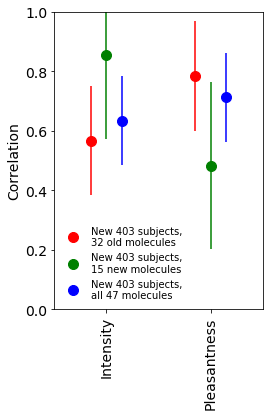

In [13]:
# Plot the results.  
import matplotlib as mpl
mpl.rcParams.update({'font.size':14})
plt.figure(figsize=(4,6))
plt.errorbar(np.arange(2)-0.15,rs['old_new'],yerr=np.tanh(1/np.sqrt(32-3)),color='r',marker='o',linestyle='',markersize=10,label='New 403 subjects,\n32 old molecules')
plt.errorbar(np.arange(2),rs['new_new'],yerr=np.tanh(1/np.sqrt(15-3)),color='g',marker='o',linestyle='',markersize=10,label='New 403 subjects,\n15 new molecules')
plt.errorbar(np.arange(2)+0.15,rs['new'],yerr=np.tanh(1/np.sqrt(47-3)),color='b',marker='o',linestyle='',markersize=10,label='New 403 subjects,\nall 47 molecules')
plt.xlim(-0.5,1.5)
plt.ylim(0,1)
plt.xticks(range(2),['Intensity','Pleasantness'],rotation=90);
plt.ylabel('Correlation')
plt.legend(fontsize=10,loc=3,frameon=0)
plt.tight_layout()
plt.savefig('../../figures/new_predictions.eps',format='eps')